# Data Pre-processing

Converting raw data into ingredients fit for our strategy recipe is an annoying yet necessary work. Here's how I cleaned and processed data for this project.

Ultimately, we want these data:

1. Industry Index Price Series (Quarterly)
2. Industry Index Total Return Series (Quarterly)
3. Industry Index Earnings Series (Quarterly)

In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from datetime import datetime, timedelta
from xquant.util import *
import seaborn as sns

In [2]:
df_div = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/dividends.csv', parse_dates=['announced'], dtype={'ticker':str})
# df_price = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/price.csv', index_col=['date'], parse_dates=['date'])
df_price = pd.read_csv('D:/Downloads/price_01.csv', index_col=['date'], parse_dates=['date'])
# df_mktcap = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/market_cap.csv', index_col=['date'], parse_dates=['date'])
df_mktcap = pd.read_csv('D:/Downloads/market_cap_01.csv', index_col=['date'], parse_dates=['date'])
df_comp = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_index_comp.csv', parse_dates=['included', 'excluded'])
df_map = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/ticker_map.csv', index_col=['key'])
df_idx = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_industry_index.csv', index_col=['Date'], parse_dates=['Date'])

In [3]:
# time range for back test
START = datetime(2000,2,1)
END = datetime(2020,12,31)

## Clean dividend data

In [4]:
df_div['ticker'] = df_div['ticker'].apply(add_suffix) # convert ticker symbol into standard format (e.g. 000001.SZ)

In [5]:
df_div.dropna(subset=['announced'], inplace=True)

## Clean Index Members Data

In [6]:
# map symbols to actual names of industry
df_comp['industry'] = df_comp['industry'].apply(lambda x: df_map.at[x,'value'])

In [7]:
# if stock is still a member of the index, set excluded time to a future data far away
df_comp['excluded'].fillna(pd.Timestamp('20991231'), inplace=True)

In [8]:
df_comp.dropna(subset=['included'], inplace=True)

## Calculate Financial Metrics for an Index

Very often we would need to look at certain metrics of an index, such as earnings and dividends. In a market capitalization weighted indices with $n$ components, its metric $m$ is calculated by:

$\sum^{n}_{i=1} w_{i} \cdot m_{i}$

where $w$ is the weight of component $i$ in the index (i.e. market cap of component $i$ divided by sum of market cap for all components).

### First calculate the scale (i.e. multiplier) for each industry index at a certain date

In [9]:
def get_scale(date) -> dict:
    d = dict.fromkeys(df_idx.columns,[])
    for i in df_idx.columns:
        total = 0
        f = get_index_weights(df_mktcap, df_comp.query(f"industry=='{i}'"), pd.Timestamp(date))
        for s in f.index:
            local_sum = f[s] * df_price.at[pd.Timestamp(date), s]
            if pd.notna(local_sum):
                total += local_sum
        if total != 0:            
            d[i] = df_idx.at[date,i]/total
        else:
            d[i] = np.nan
    return d

### Then calculate the quarterly weighted sum of a metric

In [10]:
def get_weighted_sum_div(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'ffill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                s = quarter_sum(ticker=stock, quarter=look_up, df=df, sum_col=sum_col, date_col=date_col)
                weighted_sum = w[stock] * s
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

### Quarterly Prices

This one is easy, `xquant` has a function for exactly this.

In [12]:
df_idx_q = quarter_begin(df_idx, START, END)

In [13]:
df_idx_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2000-04-03,1450.6584,1334.9933,1380.9918,1401.4697,1390.2170,1308.5405,1326.2488,1381.8595,2002.7550,1314.1241,1465.1221
2000-07-03,1547.7512,1465.1349,1446.0944,1442.5576,1469.5848,1483.4725,1325.7676,1397.3906,2066.8048,1582.6605,1494.7897
2000-10-09,1645.2645,1519.2216,1462.4722,1470.5231,1502.6199,1460.9784,1274.8601,1407.9548,1494.9085,1534.3790,1435.3936
2001-01-02,1757.2162,1694.0760,1581.9773,1597.5333,1641.7745,1685.6886,1350.0891,1518.1820,1744.5218,1667.5796,1566.1747
2001-04-02,1786.1517,1731.8992,1554.5135,1605.1410,1615.3119,1626.9918,1357.4347,1384.3689,1594.7535,1680.7876,1530.1825


### Quarterly Dividends

In [14]:
df_div_q = get_weighted_sum_div(START, END, df_div, 'div_per_share', 'announced')

100%|██████████| 83/83 [07:25<00:00,  5.37s/it]
computation completed in 445.486031293869 seconds.



In [15]:
df_div_q = df_div_q.fillna(0).set_index(df_idx_q.index)

In [16]:
df_div_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2000-04-03,0.000000,0.066754,0.014623,0.011283,0.000000,0.000000,0.510543,0.000000,0.000000,0.000000,0.0
2000-07-03,0.000000,0.029840,0.000000,0.001543,0.000000,0.099425,0.000000,0.000000,0.000000,0.000000,0.0
2000-10-09,0.038748,1.428441,0.148972,0.060397,1.136820,0.877050,0.073861,0.210596,0.000000,2.057808,0.0
2001-01-02,0.008106,0.397470,0.131768,0.054994,0.364802,1.041858,0.430310,0.083069,2.123415,1.386191,0.0
2001-04-02,0.000000,0.093654,0.000000,0.001281,0.160185,0.000000,0.014354,0.016360,0.000000,0.014427,0.0


### Quarterly Total Return Series

Simply add the price series and dividend series together and normalize start date to 1.

In [17]:
df_total_rtn_q = df_idx_q + df_div_q.fillna(0)

In [18]:
df_total_rtn_q = df_idx_q + df_div_q.fillna(0).set_index(df_idx_q.index)

In [19]:
df_total_rtn_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2000-04-03,1450.658400,1335.060054,1381.006423,1401.480983,1390.217000,1308.540500,1326.759343,1381.859500,2002.755000,1314.124100,1465.1221
2000-07-03,1547.751200,1465.164740,1446.094400,1442.559143,1469.584800,1483.571925,1325.767600,1397.390600,2066.804800,1582.660500,1494.7897
2000-10-09,1645.303248,1520.650041,1462.621172,1470.583497,1503.756720,1461.855450,1274.933961,1408.165396,1494.908500,1536.436808,1435.3936
2001-01-02,1757.224306,1694.473470,1582.109068,1597.588294,1642.139302,1686.730458,1350.519410,1518.265069,1746.645215,1668.965791,1566.1747
2001-04-02,1786.151700,1731.992854,1554.513500,1605.142281,1615.472085,1626.991800,1357.449054,1384.385260,1594.753500,1680.802027,1530.1825


Might as well see what it looks like...

In [20]:
df_total_rtn_q_plot = df_total_rtn_q.div(df_total_rtn_q.loc[df_total_rtn_q.index[0]]).mul(100)

<AxesSubplot:xlabel='Date'>

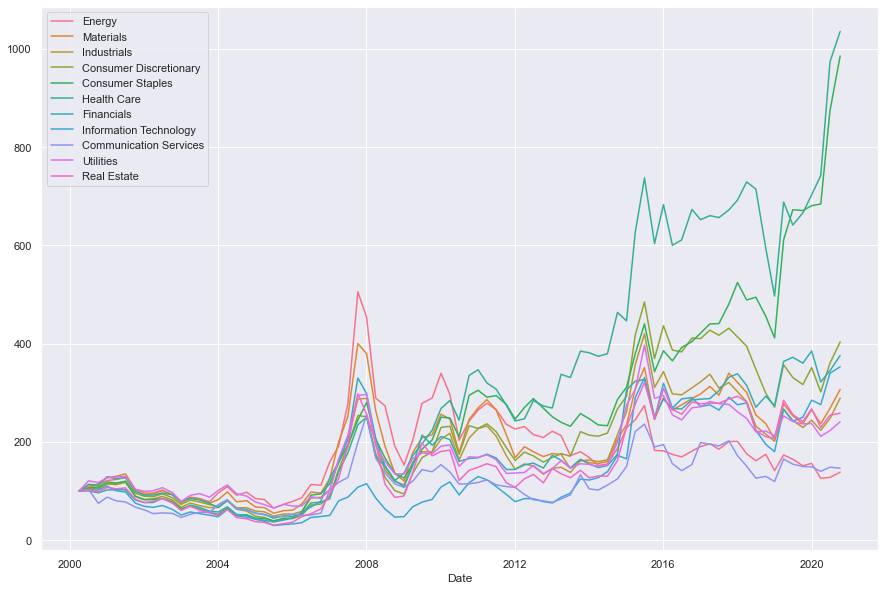

In [21]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data=df_total_rtn_q_plot, dashes=False)

### Quarterly Earnings Series

In [22]:
df_earnings = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/earnings.csv', parse_dates=['announced'], usecols=['ticker','announced','NPAP'])

In [23]:
df_earnings['ticker'] = df_earnings['ticker'].astype(str).apply(add_suffix)

Need to tweak `get_weighted_sum_div` a little bit.

In [24]:
def get_weighted_sum_earnings(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'ffill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                try:
                    eps = get_eps(
                        ticker=stock, 
                        date=day, 
                        df_price=df_price, 
                        df_mktcap=df_mktcap, 
                        df_earnings=df_earnings, 
                        earnings_col='NPAP', 
                        date_col='announced')
                except IndexError:
                    eps = 0
                weighted_sum = w[stock] * eps
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

In [25]:
df_earnings_q = get_weighted_sum_earnings(START, END, df_earnings, 'NPAP', 'announced')

100%|██████████| 83/83 [21:28<00:00, 15.52s/it]
computation completed in 1288.2835268974304 seconds.



In [26]:
df_earnings_q = df_earnings_q.set_index(df_div_q.index)

In [27]:
df_earnings_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2000-04-03,5.972076,15.185985,9.594987,30.425385,13.755961,18.234000,12.390162,26.430548,23.307415,32.322856,0.0
2000-07-03,12.607256,17.270606,15.827038,31.600723,17.855330,20.807784,18.956443,31.588726,23.307402,35.945752,0.0
2000-10-09,5.497073,10.080756,16.640746,13.034498,11.478355,11.994711,7.413158,18.085032,6.154462,21.362526,0.0
2001-01-02,5.560032,9.629518,16.145417,11.916459,12.733840,12.374809,7.131978,18.789214,6.154457,20.510423,0.0
2001-04-02,32.953885,19.463324,21.532301,24.724510,16.821288,24.097914,12.057154,20.496199,11.729494,36.574487,0.0


### Finally, scale earnings

In [28]:
df_earnings_q = df_earnings_q * (df_total_rtn_q / df_idx_q)

## Adjusting for inflation

In [29]:
df_cpi = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/cpi.csv', parse_dates=['Date'], index_col=['Date'])

In [30]:
df_cpi = df_cpi.loc[START:END]
df_cpi = df_cpi / df_cpi['CPI'][0]
df_cpi.set_index(df_earnings_q.index, inplace=True)

In [31]:
df_cpi.head()

,CPI
Date,
2000-04-03,1.000000
2000-07-03,0.996567
2000-10-09,1.014185
2001-01-02,1.024880
2001-04-02,1.015672


In [32]:
for col in df_earnings_q.columns:
    df_earnings_q[col] = df_earnings_q[col] / df_cpi['CPI']
    df_total_rtn_q[col] = df_total_rtn_q[col] / df_cpi['CPI']
    df_idx_q[col] = df_idx_q[col] / df_cpi['CPI']
    df_div_q[col] = df_div_q[col] / df_cpi['CPI']

In [33]:
df_div_q.to_csv('data\\quarterly_dividends_01.csv')
df_idx_q.to_csv('data\\quarterly_prices_01.csv')
df_total_rtn_q.to_csv('data\\quarterly_total_returns_01.csv')
df_earnings_q.to_csv('data\\quarterly_earnings_01.csv')